# Functional preference profiles

Note: This analysis is almost identical to this one: 
https://github.com/adelavega/neurosynth-lfc/blob/master/Functional%20preference%20profiles.ipynb

Here, I'll take advantage of Neurosynth's semantic data to assuming function to each sub-component of the default network. 

For each region in the clustering analysis, we're going to determine how well we can classify studies that activated the region, versus those that did not, on the basis of latent topics describing the psychological states in each study.

In [1]:
### Load dataset
from neurosynth.base.dataset import Dataset
dataset = Dataset.load('dataset_0.6_p3.pkl')
%matplotlib inline

# Load a neurosynth dataset. If you generate your own dataset, you can try this with fewer or greater number of topics
import pickle
import numpy as np
import nibabel as nib
from copy import deepcopy
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from classification import RegionalClassifier
from sklearn.metrics import roc_auc_score

## ROIs

In [2]:
joint_FPCN = nib.load('masks/Yeo_combined.nii.gz')
colors = sns.color_palette('Set1', 2)

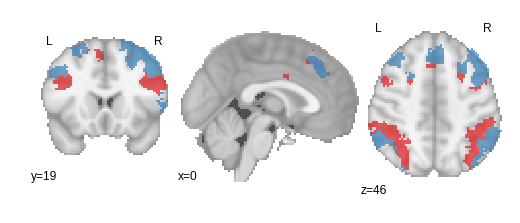

In [66]:
from nilearn import plotting as niplt
from matplotlib.colors import LinearSegmentedColormap
niplt.plot_roi(joint_FPCN, cmap=LinearSegmentedColormap.from_list('reg1', colors), draw_cross=False, cut_coords=[0, 19, 46])

In [68]:
names=['FPCN-B', 'FPCN-A']

## Functional classification procedure

First, we have applied a topic model to the Neurosynth terms in order to reduce them to 60 topics. These topics are more robust and intepretable than individual terms found in studies. 

Next, for each ROI, I've selected a set of studies that activate the region, and a set of studies that *do not*. 

Then, I've used used a naive Bayes classifier to discriminae these two sets of studies on the basis of the Neurosynth topics associated with each study. 

From this analysis we can determine:
a) How well studies that activate each ROI can be differentiated from studies that do not
b) Which topics are most predictive of activity in region (measures using the log odds ratio)

Finally, we can apply statistical tests to determine if the loading of topics onto each ROI sigificantly differ. 

In [69]:
# Instantiate a RegionalClassifier for your image and classify
clf = RegionalClassifier(dataset, joint_FPCN, GaussianNB())
clf.classify(scoring=roc_auc_score)

Classifying...
[##########] 100%


For both ROIs, we achieved moderate classification performance (comparable to previous studies)

In [70]:
clf.class_score

array([ 0.67094192,  0.63525891])

## Visualization with polar plots

Having obtained topic loadings onto each ROI from the classification, we can visualize these functional associations using a polar plot. 

Here, I'll plot the 8 strongest loading topics for each region (total is less than 16 due to functional overlap between regions.

I've named each topic subjectively, see bottom for more information on each topic

In [71]:
import pandas as pd
from plotting import plot_clf_polar

## Topic nicknames
nicknames = pd.read_csv('v4-topics-60.txt', delimiter='\t')
nicknames['topic_name'] = nicknames.apply(lambda row: '_'.join([str(row.topic_number)] + row.top_words.split(' ')[0:3]), axis=1)
nicknames = nicknames.sort_values('topic_name')

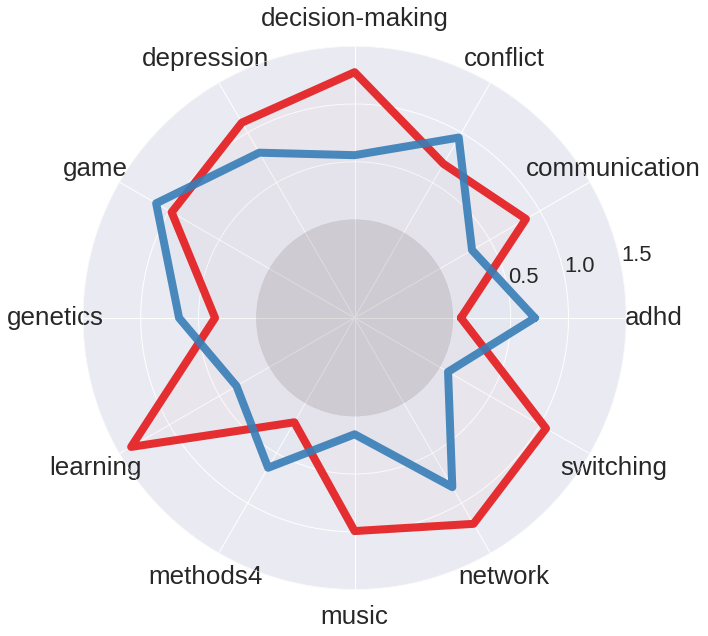

In [72]:
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)
top_topics, _ = plot_clf_polar(formated_importances,  max_val=1.5, n_top=8, palette=colors)

Overall, the functional profiles of both fronto-parietal control sub-networks are relatively similar... 

Given the we only have two regions, let's take a more detailed look below:

## Bootstrapped confidence intervals

To determine if topics loadings significantly differ between regions, one option is to calculate 95% bootstrapped confidence intervals for the log odds ratio for each topic for each region and see if the CIs overlap between the two FPCN subnetworks. 

In [73]:
import classification 

In [74]:
lor_ci = classification.bootstrap_log_odds(clf, 1000, feature_names=nicknames.nickname,
                                           region_names = names, n_jobs=7)

[##########] 100%


Below, I plot the LOR of each topic to each region (using the same colors as above) for the 10 mo

In [76]:
from matplotlib.colors import rgb2hex
%load_ext rpy2.ipython

colors_hex = [rgb2hex(c) for c in colors]
colors_hex, _ = zip(*sorted(zip(colors_hex, names), key=lambda tup: tup[1]))
colors_hex = list(colors_hex)

means = lor_ci.pivot(columns='region', index='topic_name', values='mean')
means['a>b'] = np.abs(means['FPCN-A'] - means['FPCN-B'])
means['grand_mean'] = (means['FPCN-A']  + means['FPCN-B']) / 2
sorted_abs_diff = means.sort_values('a>b').index
sorted_gm = means.sort_values('grand_mean').index

%Rpush sorted_abs_diff
%Rpush sorted_gm
%Rpush lor_ci
%Rpush colors_hex

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## All topics sorted by overall strength of assocation (to both subnetworks)

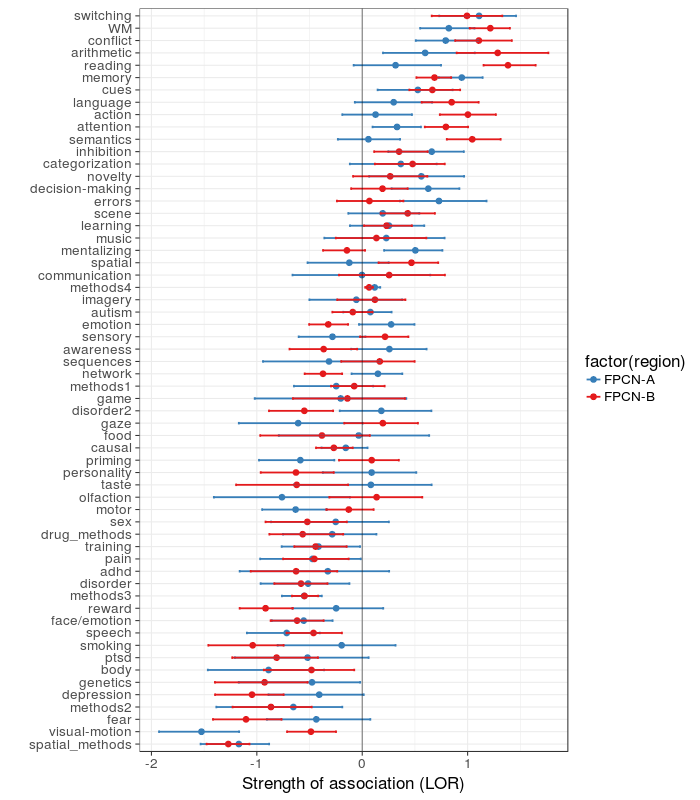

In [81]:
%%R -w 700 -h 800 
library(ggplot2)
ggplot(lor_ci, aes(mean, topic_name, group=factor(region), color=factor(region))) + geom_point(size=2.5) + 
geom_errorbarh(aes(xmin=low_ci, xmax=hi_ci), height=.2, size=.85) + geom_vline(xintercept = 0, alpha=.5) +
theme_bw(base_size = 17)  + labs(x = 'Strength of association (LOR)', y="") +
scale_color_manual(values = colors_hex) + scale_y_discrete(limits=sorted_gm)

## All topics sorted by difference in strength of association between the two networks

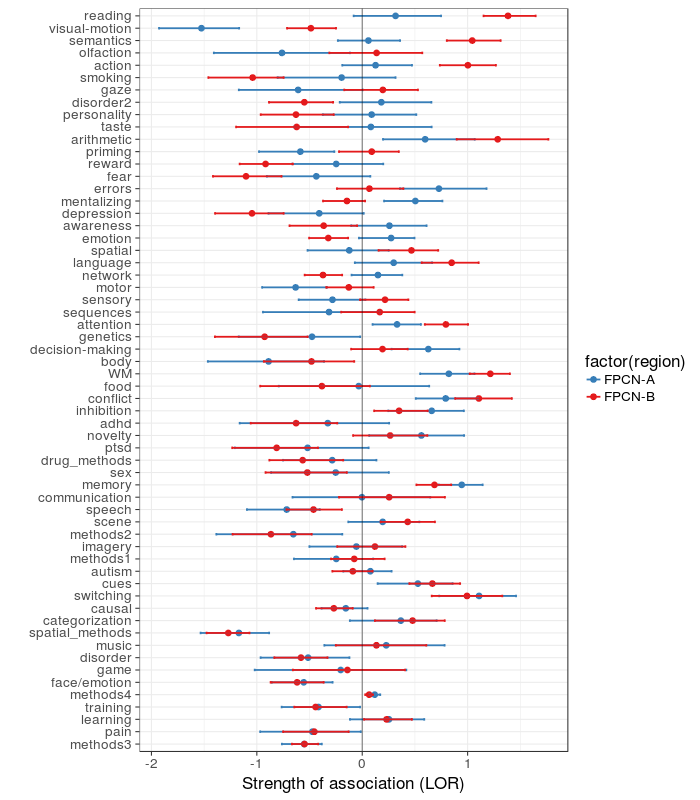

In [82]:
%%R -w 700 -h 800 
library(ggplot2)
ggplot(lor_ci, aes(mean, topic_name, group=factor(region), color=factor(region))) + geom_point(size=2.5) + 
geom_errorbarh(aes(xmin=low_ci, xmax=hi_ci), height=.2, size=.85) + geom_vline(xintercept = 0, alpha=.5) +
theme_bw(base_size = 17) + labs(x = 'Strength of association (LOR)', y="") +
scale_color_manual(values = colors_hex) + scale_y_discrete(limits=sorted_abs_diff)

# Supplemental

### Topic keys

For reference, here are the top words for each topic. The first column is the "nickname" that I assigned to this topic (and matches the plots above), and the next 9 columns are the top 9 words (in descending order) that loaded into this topic

In [64]:
pd.read_csv('v4-topics-60.txt', delimiter='\t').ix[:, 2:11]

,nickname,top_words,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,mentalizing,social,empathy,moral,person,judgments,mentalizing,mental,mind
1,sequences,sequences,timing,alpha,sequence,duration,beta,rhythm,motor
2,sex,women,sex,females,males,male,female,sexual,ts
3,game,acupuncture,game,unfair,er,stimulation,offers,playing,acupoint
4,errors,error,errors,monitoring,correct,feedback,creative,creativity,driving
5,speech,speech,auditory,sounds,sound,perception,voice,acoustic,listening
6,emotion,emotional,emotion,regulation,affective,pictures,emotions,arousal,affect
7,body,body,bodies,sci,con,image,bladder,bodily,ownership
8,conflict,conflict,interference,incongruent,stroop,congruent,selection,competition,color
9,olfaction,olfactory,shape,shapes,writing,odor,texture,drawing,odors


## Permutation tests

A supplemental test would be the use permutation testing to determine which topics (for each ROI) are signficantly different from zero. Usually this would be higher up, but given the similarly of these two regions, it may be more useful to focus on their differences using the above test

In [ ]:
%load_ext autoreload
%autoreload 1
%aimport classification

First, using `permute_log_odds_ratio` we perform a permutation test for each region - topic log odds ratio, resulting in the z-score and p-value of the observed log odds ratio in permuted null distribution. Small p-values indicate it is inprobably we would observe the given log odds ratio under the null distribution. 

Note that this function takes a fitted RegionalClassifier model (that we generated above) and the number of times to resample as required arguments

In [ ]:
# These are the names of each region given the manuscript
names = ['posterior', 'anterior']

In [ ]:
from classification import permute_log_odds
lor_z = classification.permute_log_odds(clf, 100, feature_names=nicknames.nickname, region_names = names)

Next, we must adjust the p-values for multiple comparisons. To do so, we will use False Discovery Rate, and focus only on a subject of tests. As such, I'm only going to include the topics that we focused on for the above plots

In [ ]:
select_ps = lor_z[lor_z.nickname.isin(selected_topics)]

Finally, we use `multipletests` from the stats models package to correct our p-values given an alpha of 0.01. We then consider the null hypothesis rejected if the adjusted p-value is less than 0.05 and the sign is positive (excluding less easily interpreted negative associations)

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(select_ps.p, alpha=0.01, method='fdr_tsbky')

select_ps['reject_01'] = reject & (select_ps.lor_z > 0) # Was the null hypothesis rejected?
select_ps['p_corr_01'] = p_corr # Adjusted p-value

The resulting table includes the FDR corrected p-value for each region / topic combination, and if the null hypothesis has been rejected